#**Procedimiento para análisis de plagas**


##**Definición del problema**

**Objetivo:** Predecir el nivel de riesgo de plaga para el próximo mes utilizando datos de los 6 meses previos. En esta etapa se define claramente el problema y qué datos se requieren. Por ejemplo, podría tratarse de predecir el número de insectos/plagas esperados en un cultivo el mes siguiente, basándose en factores históricos como clima, humedad, tratamientos, etc. Es importante identificar qué variables influyen en el riesgo de plaga (temperatura, precipitación, humedad, tipo de cultivo, incidencias de plaga observadas, etc.) y cómo obtener esos datos. También es posible predecir datos de producción basados en la información previa.

###**Carga de datos y construcción del DataFrame**

In [1]:
# Importación de librerias
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer

from sklearn.linear_model import Ridge, PoissonRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_poisson_deviance

from sklearn.model_selection import TimeSeriesSplit

import matplotlib.pyplot as plt
import seaborn as sns

# Gráficas dinámicas
import plotly.graph_objects as go
import plotly.express as px


In [2]:
# Cargar datos de github
RAW_URL = "https://raw.githubusercontent.com/Da-Pe-Al/Analisis-de-plagas/main/plagas_sintetico_5000.csv"

# Leer csv
df = pd.read_csv(RAW_URL, encoding="utf-8-sig")

# Normalizar nombres de las columnas
df = df.rename(columns={
    "TemperaturaPromedio (°C)": "Temperatura",
    "Precipitación (mm)": "Precipitación",
    "IncidenciaPlaga": "Plaga",
})

# Asegurar la columna 'Mes' como datetime mensual
df["Mes"] = pd.to_datetime(df["Mes"],format="%Y-%m", errors="coerce").dt.to_period("M").dt.to_timestamp("s")


# Convertir datos a tipo numéricos y cambiar Nun si no hay datos
df["Temperatura"]  = pd.to_numeric(df["Temperatura"], errors="coerce")
df["Precipitación"]  = pd.to_numeric(df["Precipitación"], errors="coerce")
df["Plaga"] = pd.to_numeric(df["Plaga"], errors="coerce").astype("Int64")

# Orden temporal
df = df.sort_values("Mes").reset_index(drop=True)



print(df.head())
print(df.dtypes)
print(df.describe())


         Mes  Temperatura  Precipitación  Plaga
0 2019-01-01        18.53            0.0      0
1 2019-01-01        16.32           30.2      1
2 2019-01-01        18.62           49.2      1
3 2019-01-01        20.07           17.3      2
4 2019-01-01        19.61           24.0      3
Mes              datetime64[ns]
Temperatura             float64
Precipitación           float64
Plaga                     Int64
dtype: object
                                 Mes  Temperatura  Precipitación     Plaga
count                           5000  5000.000000    5000.000000    5000.0
mean   2022-06-12 22:26:58.560000256    22.942204      81.049120    4.9242
min              2019-01-01 00:00:00    11.760000       0.000000       0.0
25%              2020-09-01 00:00:00    19.700000      32.775000       2.0
50%              2022-06-01 00:00:00    23.145000      59.500000       4.0
75%              2024-04-01 00:00:00    26.112500     140.000000       8.0
max              2025-12-01 00:00:00    34.87

### **Preprocesamiento y Normalización**

In [3]:
##Se utilizara esta normalización para modelos de Regresion Lineal Regularizada, SVM o Redes Neuronales

# # Extrae mes (1-12) desde MesLabel
# def extract_month_col(X: pd.DataFrame) -> pd.DataFrame:
#     m = pd.to_datetime(X['Mes']).dt.month.to_frame(name='month')
#     return m

# month_extractor = FunctionTransformer(extract_month_col, validate=False)

# # Aplica log1p SOLO a Precipitación; Temperatura pasa tal cual;
# log_prec = ColumnTransformer(
#     transformers=[
#         ('prec_log', FunctionTransformer(np.log1p, validate=False), ['Precipitación']),
#         ('temp_passthrough', 'passthrough', ['Temperatura'])
#     ],
#     remainder='drop'
# )

##Tratar datos nulos sustituyendolos por la mediana
# num_scaled = Pipeline(steps=[
#     ('impute', SimpleImputer(strategy='median')),
#     ('log_prec', log_prec),
#     ('scale', StandardScaler())
# ])

##Convertir los nombres de los meses a valores numéricos de 1-12
# time_pipe = Pipeline(steps=[
#     ('month', month_extractor),
#     ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
# ])

##Juntar los datos en una sola variable
# preprocess = ColumnTransformer(
#     transformers=[
#         ('num', num_scaled, ['Temperatura','Precipitación']),
#         ('time', time_pipe, ['Mes']),
#     ],
#     remainder='drop'
# )

# X = df[['Mes', 'Temperatura', 'Precipitación']].copy()

# X_feat = preprocess.fit_transform(X)  # numpy ndarray con TODAS las transformaciones aplicadas

# # Construir nombres de las columnas de salida
# # Numéricos (dos columnas: precipitación transformada y temperatura escalada)
# num_names = ['prec_scaled', 'temp_scaled']

# # Tomar las categorías de meses transformadas por OneHot
# month_cats = preprocess.named_transformers_['time'].named_steps['onehot'].categories_[0]
# time_names = [f'month_{int(m)}' for m in month_cats]  # month_1..month_12

# feat_names = num_names + time_names

# # Nuevo DataFrame normalizado
# df_norm = pd.DataFrame(X_feat, columns=feat_names)

# # Añadir la variable objetivo para análisis conjunto
# if 'Plaga' in df.columns:
#     df_norm = pd.concat([df_norm, df['Plaga'].reset_index(drop=True)], axis=1)

# # Verifica
# print(df_norm.head())
# print(df_norm.dtypes)
# print(df.head())


###**Análisis exploratorio de los Datos**

       Temperatura     Plaga  Precipitación
count  5000.000000    5000.0    5000.000000
mean     22.942204    4.9242      81.049120
std       3.947848  3.938319      59.856111
min      11.760000       0.0       0.000000
25%      19.700000       2.0      32.775000
50%      23.145000       4.0      59.500000
75%      26.112500       8.0     140.000000
max      34.870000      23.0     239.400000


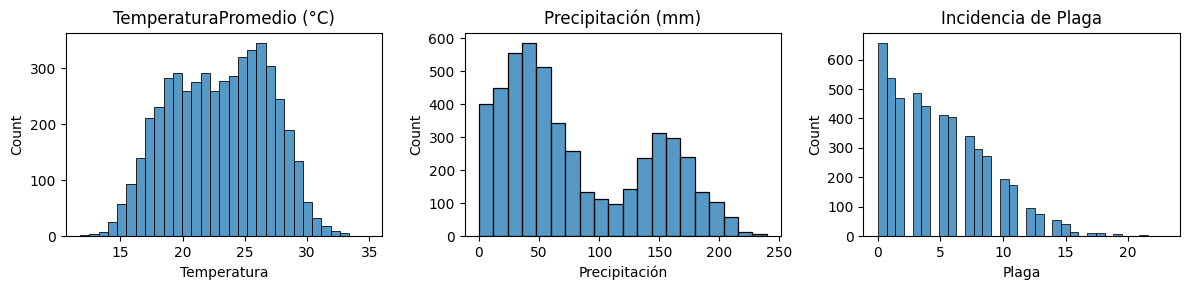

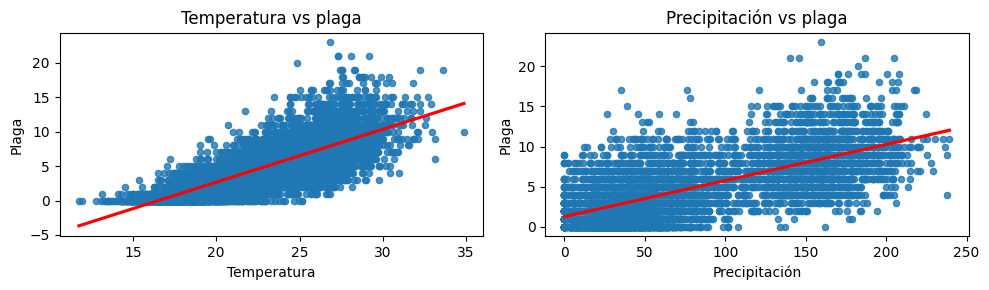

In [4]:
# EDA Sin Resample Mensual
cmap = sns.diverging_palette(220, 10, as_cmap=True) # Definir la relación nula=0 como color blanco

print(df[['Temperatura', 'Plaga', 'Precipitación']].describe())

# Distribuciones
fig, axes = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(df['Temperatura'], ax=axes[0]); axes[0].set_title('TemperaturaPromedio (°C)')
sns.histplot(df['Precipitación'], ax=axes[1]); axes[1].set_title('Precipitación (mm)')
sns.histplot(df['Plaga'], ax=axes[2]); axes[2].set_title('Incidencia de Plaga')
plt.tight_layout(); plt.show()

# Dispersión
fig, axes = plt.subplots(1, 2, figsize=(10,3))
sns.regplot(x='Temperatura', y='Plaga', data=df, ax=axes[0], line_kws={'color':'red'},scatter_kws={"s": 20}); axes[0].set_title('Temperatura vs plaga')
sns.regplot(x='Precipitación', y='Plaga', data=df, ax=axes[1], line_kws={'color':'red'},scatter_kws={"s": 20}); axes[1].set_title('Precipitación vs plaga')
plt.tight_layout(); plt.show()

# Correlación (Pearson)
corr = df[['Temperatura','Precipitación','Plaga']].corr(method='pearson')
#Eliminar la parte superior del cuadrado del Heat map
mascara = np.zeros_like(corr, dtype=bool)
mascara[np.triu_indices_from(mascara)] = True
plt.figure(figsize=(3.2,3))
sns.heatmap(corr, mask=mascara, annot=True, fmt='.2f', cmap=cmap)
plt.title('Pearson corr'); plt.show()


       Temperatura      Plaga  Precipitación
count    84.000000       84.0      84.000000
mean     22.985722   4.972127    4824.352381
std       3.425719   2.989443    3435.721299
min      17.649643   0.821429    1048.600000
25%      19.647083   2.233333    2105.275000
50%      23.469842   4.797523    3131.400000
75%      26.326866   8.208333    8136.350000
max      27.723226  10.465517   13429.900000


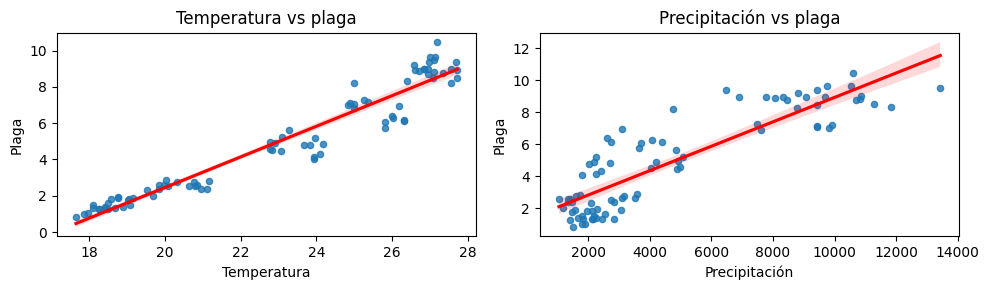

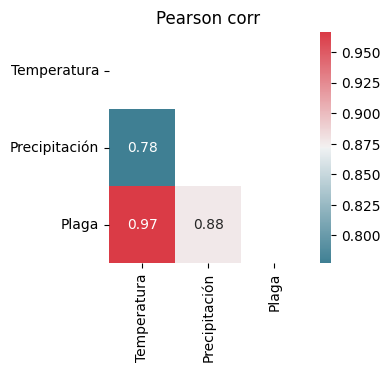

In [5]:
# Resample mensual
df2 = (df.set_index("Mes")
        .resample("MS")
        .agg({
            "Temperatura": "mean",
            "Precipitación": "sum",
            "Plaga": "mean"
        })
        .reset_index()
)
# EDA Con Resample Mensual
print(df2[['Temperatura', 'Plaga', 'Precipitación']].describe())

# Distribuciones
fig, axes = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(df2['Temperatura'], ax=axes[0]); axes[0].set_title('TemperaturaPromedio (°C)')
sns.histplot(df2['Precipitación'], ax=axes[1]); axes[1].set_title('Precipitación (mm)')
sns.histplot(df2['Plaga'], ax=axes[2]); axes[2].set_title('Incidencia de Plaga')
plt.tight_layout(); plt.show()

# Dispersión
fig, axes = plt.subplots(1, 2, figsize=(10,3))
sns.regplot(x='Temperatura', y='Plaga', data=df2, ax=axes[0], line_kws={'color':'red'},scatter_kws={"s": 20}); axes[0].set_title('Temperatura vs plaga')
sns.regplot(x='Precipitación', y='Plaga', data=df2, ax=axes[1], line_kws={'color':'red'},scatter_kws={"s": 20}); axes[1].set_title('Precipitación vs plaga')
plt.tight_layout(); plt.show()

# Correlación (Pearson)
corr = df2[['Temperatura','Precipitación','Plaga']].corr(method='pearson')
plt.figure(figsize=(3.2,3))
sns.heatmap(corr, mask=mascara, annot=True, fmt='.2f', cmap=cmap)
plt.title('Pearson corr'); plt.show()

# Figura base
fig = go.Figure()

# Barras: Temperatura (y)
fig.add_trace(go.Bar(
    name="TemperaturaPromedio (°C)",
    x=df2["Mes"],
    y=df2["Temperatura"],
    hovertemplate="Mes=%{x}<br>Temp=%{y:.2f} °C<extra></extra>"
))

# Barras: Precipitación (y2)
fig.add_trace(go.Bar(
    name="Precipitación (mm)",
    x=df2["Mes"],
    y=df2["Precipitación"],
    yaxis="y2",
    hovertemplate="Mes=%{x}<br>Temp=%{y:.2f} °C<extra></extra>"
))

# Dispersión: Incidencia de plaga (y3)
fig.add_trace(go.Scatter(
    name="Incidencia de plaga",
    x=df2["Mes"],
    y=df2["Plaga"],
    mode="lines+markers",
    yaxis="y3",
    hovertemplate="Mes=%{x}<br>Temp=%{y:.2f} °C<extra></extra>"
))

# --- Layout con 3 ejes Y ---
fig.update_layout(
    title="Clima vs Incidencia de Plaga",
    barmode="group",  # Hay otras opciones como: "overlay" o "stack"
    hovermode="x unified",
    legend=dict(orientation="h", y=1.1),
    # 1) Deja margen derecho reduciendo el dominio del eje X
    xaxis=dict(
        title="Fecha",
        type="date",
        domain=[0.0, 0.82],        # el área de dibujo termina en 0.82
        rangeslider=dict(visible=True)
    ),

    # y (izquierda) - Temperatura
    yaxis=dict(title="Temperatura (°C)", showgrid=True),

    # y2 (derecha, al borde del dominio x=0.82) - Precipitación
    yaxis2=dict(
        title="Precipitación (mm)",
        overlaying="y",
        side="right",
        position=0.82
    ),

    # y3 (más a la derecha, en el margen) - Incidencia
    yaxis3=dict(
        title="Incidencia de plaga",
        overlaying="y",
        side="right",
        anchor="free",             # Colocar el eje después del eje x
        position=0.92,             # Fuera de la posición 0.82
        showgrid=False
    ),

    margin=dict(r=110)             # deja espacio visual para el tercer eje
)

fig.show()

##**Regresión lineal**

##Modelo SIN resampleo mensual

In [6]:
from sklearn.model_selection import train_test_split
from statsmodels.formula.api import ols
import statsmodels.api as sm

#Separación de los datos de prueba y de entrenamiento de la muestra sin resampleo mensual
y = df['Plaga']
X= df.drop(columns='Plaga')

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=230) #Fijar random_state para poder reproducir el modelo

#Agregar constante para mejor ajuste
X_train = sm.add_constant(X_train, has_constant='add')
X_test  = sm.add_constant(X_test, has_constant='add')

#Creando el modelo con todas las variables
modelo_Temp = sm.OLS(y_train,X_train[['const','Temperatura']]).fit()
modelo_Prec = sm.OLS(y_train,X_train[['const','Precipitación']]).fit()
modelo_mixto = sm.OLS(y_train,X_train[['const','Temperatura','Precipitación']]).fit()
#Resumen de los modelos
modelos=[modelo_Temp,modelo_Prec,modelo_mixto]
for i,j in enumerate(modelos):
  print(f'********************************************************** El modelo {i} tiene el siguiente resumen ********************************************************** ')
  print(j.summary(), '\n\n')

********************************************************** El modelo 0 tiene el siguiente resumen ********************************************************** 
                            OLS Regression Results                            
Dep. Variable:                  Plaga   R-squared:                       0.591
Model:                            OLS   Adj. R-squared:                  0.590
Method:                 Least Squares   F-statistic:                     5046.
Date:                Tue, 23 Sep 2025   Prob (F-statistic):               0.00
Time:                        23:33:15   Log-Likelihood:                -8249.2
No. Observations:                3500   AIC:                         1.650e+04
Df Residuals:                    3498   BIC:                         1.651e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>

##Modelo con Resampleo Mensual

In [8]:
#Separación de los datos de prueba y de entrenamiento de la muestra sin resampleo mensual
y2 = df2['Plaga']
X2= df2.drop(columns='Plaga')

X_train2, X_test2, y_train2, y_test2= train_test_split(X2,y2,test_size=0.3, random_state=230) #Fijar random_state para poder reproducir el modelo

#Agregar constante para mejor ajuste
X_train2 = sm.add_constant(X_train2, has_constant='add')
X_test2  = sm.add_constant(X_test2, has_constant='add')

#Creando el modelo con todas las variables
modelo_Temp2 = sm.OLS(y_train2,X_train2[['const','Temperatura']]).fit()
modelo_Prec2 = sm.OLS(y_train2,X_train2[['const','Precipitación']]).fit()
modelo_mixto2 = sm.OLS(y_train2,X_train2[['const','Temperatura','Precipitación']]).fit()
#Resumen de los modelos
modelos2=[modelo_Temp2,modelo_Prec2,modelo_mixto2]
for k,l in enumerate(modelos2):
  print(f'********************************************************** El modelo {k} tiene el siguiente resumen ********************************************************** ')
  print(l.summary(), '\n\n')

********************************************************** El modelo 0 tiene el siguiente resumen ********************************************************** 
                            OLS Regression Results                            
Dep. Variable:                  Plaga   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     714.6
Date:                Tue, 23 Sep 2025   Prob (F-statistic):           1.44e-33
Time:                        23:33:41   Log-Likelihood:                -69.055
No. Observations:                  58   AIC:                             142.1
Df Residuals:                      56   BIC:                             146.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>

In [9]:
from sklearn.metrics import r2_score


# Evaluación de los modelos
prevision_temp = modelo_Temp.predict(X_test[['const','Temperatura']])
prevision_prec = modelo_Prec.predict(X_test[['const','Precipitación']])
prevision_mixto = modelo_mixto.predict(X_test[['const','Temperatura','Precipitación']])
prevision_temp2 = modelo_Temp2.predict(X_test2[['const','Temperatura']])
prevision_prec2 = modelo_Prec2.predict(X_test2[['const','Precipitación']])
prevision_mixto2 = modelo_mixto2.predict(X_test2[['const','Temperatura','Precipitación']])


#Cálculo de R2 de Entrenamiento
r2_temp_train = modelo_Temp.rsquared
r2_prec_train = modelo_Prec.rsquared
r2_mixto_train = modelo_mixto.rsquared
r2_temp2_train = modelo_Temp2.rsquared
r2_prec2_train = modelo_Prec2.rsquared
r2_mixto2_train = modelo_mixto2.rsquared

#Cálculo de R2 de Prueba
r2_temp_test = r2_score(y_test, prevision_temp)
r2_prec_test = r2_score(y_test, prevision_prec)
r2_mixto_test = r2_score(y_test, prevision_mixto)
r2_temp2_test = r2_score(y_test2, prevision_temp2)
r2_prec2_test = r2_score(y_test2, prevision_prec2)
r2_mixto2_test = r2_score(y_test2, prevision_mixto2)


#Resumen Comparativo de R2 de Prueba (OLS)
#Creación de diccionario para el df
comp_modelos = {
    'Modelos': [
        'Temperatura (sin Resampleo)',
        'Precipitación  (sin Resampleo)',
        'Mixto  (sin Resampleo)',
        'Temperatura (Resampleado)',
        'Precipitación (Resampleado)',
        'Mixto (Resampleado)'
    ],
    'R2_train': [
        round(r2_temp_train,3),
        round(r2_prec_train,3),
        round(r2_mixto_train,3),
        round(r2_temp2_train,3),
        round(r2_prec2_train,3),
        round(r2_mixto2_train,3)

    ]
    ,
    'R2_test': [
        round(r2_temp_test,3),
        round(r2_prec_test,3),
        round(r2_mixto_test,3),
        round(r2_temp2_test,3),
        round(r2_prec2_test,3),
        round(r2_mixto2_test,3)

    ]
}

# Crear el DataFrame a partir del diccionario
df_r2_resumen = pd.DataFrame(comp_modelos)

# Mostrar el DataFrame
print("Resumen de R2 de Prueba para Modelos OLS:")
display(df_r2_resumen)

Resumen de R2 de Prueba para Modelos OLS:


Modelos  R2_train  R2_test
0     Temperatura (sin Resampleo)     0.591    0.599
1  Precipitación  (sin Resampleo)     0.469    0.454
2          Mixto  (sin Resampleo)     0.645    0.653
3       Temperatura (Resampleado)     0.927    0.946
4     Precipitación (Resampleado)     0.750    0.805
5             Mixto (Resampleado)     0.974    0.973

In [10]:
modelo_Temp_robust_eval = modelo_Temp.get_robustcov_results(cov_type='HAC', maxlags=12)  # Newey-West
modelo_Prec_robust_eval = modelo_Prec.get_robustcov_results(cov_type='HAC', maxlags=12)  # Newey-West
modelo_mixto_robust_eval = modelo_mixto.get_robustcov_results(cov_type='HAC', maxlags=12)  # Newey-West
modelo_Temp2_robust_eval = modelo_Temp2.get_robustcov_results(cov_type='HAC', maxlags=12)  # Newey-West
modelo_Prec2_robust_eval = modelo_Prec2.get_robustcov_results(cov_type='HAC', maxlags=12)  # Newey-West
modelo_mixto2_robust_eval = modelo_mixto2.get_robustcov_results(cov_type='HAC', maxlags=12)  # Newey-West


robust_eval=[modelo_Temp_robust_eval,modelo_Prec_robust_eval,modelo_mixto_robust_eval,modelo_Temp2_robust_eval,modelo_Prec2_robust_eval,modelo_mixto2_robust_eval]
for m,n in enumerate(robust_eval):
  print(f'********************************************************** El modelo {m} tiene el siguiente resumen ********************************************************** ')
  print(n.summary(), '\n\n')

********************************************************** El modelo 0 tiene el siguiente resumen ********************************************************** 
                            OLS Regression Results                            
Dep. Variable:                  Plaga   R-squared:                       0.591
Model:                            OLS   Adj. R-squared:                  0.590
Method:                 Least Squares   F-statistic:                     5397.
Date:                Tue, 23 Sep 2025   Prob (F-statistic):               0.00
Time:                        23:34:12   Log-Likelihood:                -8249.2
No. Observations:                3500   AIC:                         1.650e+04
Df Residuals:                    3498   BIC:                         1.651e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                  coef    std err          t      P>

##**Modelo Lightgbm**

In [11]:
# Definir variables exógenas y endógenas para SARIMAX
features = [
    'Temperatura', 'Precipitación',
    'Temperatura_lag1', 'Precipitación_lag1',#Valores del mes anterior
    'Temperatura_roll3', 'Precipitación_roll3',#Medias moviles de 3 periodos
    'sin1', 'cos1'#Transformaciones trigonométricas para comportamientos cíclicos
]
target = 'Plaga' #Definición de la variable dependiente

print("Las variables exógenas son:", features)
print("Las variables endógenas son:", target)

Las variables exógenas son: ['Temperatura', 'Precipitación', 'Temperatura_lag1', 'Precipitación_lag1', 'Temperatura_roll3', 'Precipitación_roll3', 'sin1', 'cos1']
Las variables endógenas son: Plaga


In [14]:
# Definir la función para agregar escala temporal
def add_time_features(d):
    out = d.copy()
    # Temporalidad mensual para la plaga
    out['Plaga_lag1']  = out['Plaga'].shift(1)
    out['Plaga_lag12'] = out['Plaga'].shift(12)

    # Lags de las variables exógenas
    out['Temperatura_lag1']   = out['Temperatura'].shift(1)
    out['Precipitación_lag1'] = out['Precipitación'].shift(1)

    # Medias móviles de 3 periodos
    out['Temperatura_roll3']   = out['Temperatura'].shift(1).rolling(3).mean()
    out['Precipitación_roll3'] = out['Precipitación'].shift(1).rolling(3).mean()

    # Aplicación de la transformada de Fourier (s = 12 para mensual)
    s = 12
    t = np.arange(len(out))
    out['sin1'] = np.sin(2*np.pi*t/s)
    out['cos1'] = np.cos(2*np.pi*t/s)

    return out

# Agregar las variables temporales a un nuevo df
df_feat = add_time_features(df)

# Drop NaNs after creating features to ensure a continuous time series for SARIMAX
df_feat = df_feat.dropna().copy()


# 80/20 by time
n = int(len(df_feat)*0.8)
df_train = df_feat.iloc[:n].copy()
df_test  = df_feat.iloc[n:].copy()

In [15]:
import lightgbm as lgb
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Seleccionar los datos de entrenamiento y de prueba
X_train_lgbm = df_train[features]
y_train_lgbm = df_train[target]
X_test_lgbm  = df_test[features]
y_test_lgbm  = df_test[target]

# Inicializar y entrenar el modelo
lgb_model = lgb.LGBMRegressor(random_state=42)
lgb_model.fit(X_train_lgbm, y_train_lgbm)

# Realizar las predicciones
y_pred_train_lgb = lgb_model.predict(X_train_lgbm)
y_pred_test_lgb = lgb_model.predict(X_test_lgbm)

# Evaluar el modelo
def eval_metrics(y_true, y_pred, name=''):
    r2   = r2_score(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    print(f"{name} R2={r2:.3f} | RMSE={rmse:.3f} | MAE={mae:.3f}")

print("LightGBM Regressor Metrics:")
eval_metrics(y_train_lgbm, y_pred_train_lgb, 'Train')
eval_metrics(y_test_lgbm,  y_pred_test_lgb,  'Test')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 3990, number of used features: 8
[LightGBM] [Info] Start training from score 4.897243
LightGBM Regressor Metrics:
Train R2=0.832 | RMSE=2.603 | MAE=1.227
Test R2=0.625 | RMSE=5.806 | MAE=1.802


In [16]:
def walk_forward_eval(df_feat, features, k=5):
    idx = df_feat.index
    folds = np.array_split(np.arange(len(df_feat)), k)
    scores = []
    for i in range(1, k):
        tr_idx = np.concatenate(folds[:i])
        te_idx = folds[i]

        train = df_feat.iloc[tr_idx].dropna()
        test  = df_feat.iloc[te_idx].dropna()
        if len(test)==0 or len(train)==0:
            continue

        Xtr = sm.add_constant(train[features]).astype(float)
        ytr = train['Plaga'].astype(float)
        Xte = sm.add_constant(test[features], has_constant='add').astype(float)
        yte = test['Plaga'].astype(float)


        m = sm.OLS(ytr, Xtr).fit()
        yhat = m.predict(Xte)
        scores.append(r2_score(yte, yhat))
    return scores

scores = walk_forward_eval(df_feat, features, k=6)
print("R2 por bloque (walk-forward):", np.round(scores,3), " | Promedio:", np.mean(scores))

R2 por bloque (walk-forward): [0.606 0.642 0.646 0.647 0.666]  | Promedio: 0.641367662283019


##Optimizacion de hiperparametros del modelo Lightgbm

In [ ]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor

#Establecer parametros
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 63, 127],
    'max_depth': [-1, 10, 20],
    'min_child_samples': [20, 30, 50],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5],
}
#Establecer separacion de bloques
tscv = TimeSeriesSplit(n_splits=5)

# Drop the 'Mes' column from X_train and X_test for LightGBM
X_train_lgbm_grid = X_train.drop(columns=['Mes', 'const'])
X_test_lgbm_grid = X_test.drop(columns=['Mes', 'const'])


#Establecer lo parametros para grid_search
lgbm = LGBMRegressor(random_state=42)
grid_search = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1 # Use all available cores
)

#Iniciar la optimizacion
grid_search.fit(X_train_lgbm_grid, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 3500, number of used features: 2
[LightGBM] [Info] Start training from score 4.974571


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LGBMRegressor(random_state=42), n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [-1, 10, 20],
                         'min_child_samples': [20, 30, 50],
                         'n_estimators': [100, 200, 300],
                         'num_leaves': [31, 63, 127],
                         'reg_alpha': [0, 0.1, 0.5],
                         'reg_lambda': [0, 0.1, 0.5], 'subsample': [0.8, 1.0]},
             scoring='neg_mean_squared_error')

In [12]:
# Obtener los mejores hiperparametros del modelo
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print("Mejores hiperparámetros encontrados:")
print(best_params)

NameError: name 'grid_search' is not defined

In [ ]:
# Aplicar los mejores parámetros para realizar predicciones
y_pred_test_optimized = best_estimator.predict(X_test.drop(columns=['Mes', 'const']))

# Evaluación del modelo optimizado
print("\nMétricas del modelo LightGBM optimizado en el conjunto de prueba:")
eval_metrics(y_test, y_pred_test_optimized, 'Test Optimizado')


Métricas del modelo LightGBM optimizado en el conjunto de prueba:
Test Optimizado R2=0.643 | RMSE=5.168 | MAE=1.727


##**Modelo SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors)**

In [21]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Exógenas (sin target lags aquí; SARIMAX ya maneja AR/MA/SA)
exog_train = df_train[['Temperatura','Precipitación','sin1','cos1']]
exog_test  = df_test[['Temperatura','Precipitación','sin1','cos1']]

# Establecer la frecuencia mensual para el modelo ('MS')
df_train.index.freq = 'MS'
df_test.index.freq = 'MS'
exog_train.index.freq = 'MS'
exog_test.index.freq = 'MS'


# Orden simple (p,q,d)(p,q,d,s): ARIMA(1,0,1) estacional (1,0,1,12)
# p= Dependencia del periodo anterior
# q=diferencia para eliminar tendencia
# d=Dependencia de la media
# s=Dependencia del periodo

sarimax_model = SARIMAX(
    endog=df_train['Plaga'],
    exog=exog_train,
    order=(0,0,1),
    seasonal_order=(0,1,1,12),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)


pred = sarimax_model.predict(start=0, end=len(df_test)-1, exog=exog_test)
print("R2 test (SARIMAX):", r2_score(df_test['Plaga'], pred))
print(sarimax_model.summary())

R2 test (SARIMAX): -8.572951824098352e+20
                                     SARIMAX Results                                      
Dep. Variable:                              Plaga   No. Observations:                 3990
Model:             SARIMAX(0, 0, 1)x(0, 1, 1, 12)   Log Likelihood              -10308.043
Date:                            Tue, 23 Sep 2025   AIC                          20630.085
Time:                                    23:46:37   BIC                          20674.080
Sample:                                         0   HQIC                         20645.687
                                           - 3990                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Temperatura       0.5480      0.017     32.229      0.000       0.

## Evaluación Walk-Forward para SARIMAX




In [20]:
# =======================
# SARIMAX Walk-Forward CV
# =======================
import warnings
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.sm_exceptions import ValueWarning as SMValueWarning

# (Opcional) Suprime el warning de "frequency inferred" si ya validaste que tu índice es mensual
warnings.filterwarnings("ignore", category=SMValueWarning, module="statsmodels.tsa.base.tsa_model")

def sarimax_walk_forward_eval(
    df_feat: pd.DataFrame,
    features,
    order=(0, 0, 1),
    seasonal_order=(0, 1, 1, 12),
    k=6,
    h=3,
    min_train=24,
    enforce_stationarity=False,
    enforce_invertibility=False,
    verbose=False
):
    """
    df_feat: DataFrame con DatetimeIndex (mensual) y columnas: 'Plaga' + features.
             Si no tiene DatetimeIndex, intentará usar la columna 'Mes' como índice.
    features: lista de exógenas a usar.
    order, seasonal_order: órdenes SARIMAX.
    k: número de splits.
    h: tamaño del bloque de validación (h pasos).
    min_train: tamaño mínimo del bloque de entrenamiento en meses.
    """
    # Asegurar índice de fechas ordenado y sin duplicados
    if not isinstance(df_feat.index, pd.DatetimeIndex):
        if 'Mes' not in df_feat.columns:
            raise ValueError("df_feat no tiene DatetimeIndex ni columna 'Mes'.")
        df_feat = df_feat.set_index('Mes')
    df_feat = df_feat.sort_index()
    df_feat = df_feat[~df_feat.index.duplicated(keep='first')]

    # IMPORTANTE:
    # No forzamos .asfreq('MS') si hay huecos. Si tu serie es mensual sin huecos, puedes activar la línea:
    # df_feat = df_feat.asfreq('MS')

    tscv = TimeSeriesSplit(n_splits=k, test_size=h)

    r2_list, mae_list, rmse_list = [], [], []
    used_folds = 0

    for fold, (train_index, test_index) in enumerate(tscv.split(df_feat), start=1):
        train = df_feat.iloc[train_index].copy()
        test  = df_feat.iloc[test_index].copy()

        # Requisitos mínimos
        if len(train) < min_train or len(test) == 0:
            if verbose:
                print(f"[Fold {fold}] Saltado: train={len(train)} test={len(test)} (min_train={min_train})")
            r2_list.append(np.nan); mae_list.append(np.nan); rmse_list.append(np.nan)
            continue

        y_train = train['Plaga']
        y_test  = test['Plaga']
        exog_train = train[features]
        exog_test  = test[features]

        try:
            model = SARIMAX(
                endog=y_train,
                exog=exog_train,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=enforce_stationarity,
                enforce_invertibility=enforce_invertibility
            ).fit(disp=False)

            # Pronóstico estrictamente out-of-sample
            fc = model.get_forecast(steps=len(test), exog=exog_test)
            y_pred = fc.predicted_mean

            # Métricas
            mae  = mean_absolute_error(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            r2 = np.nan
            if len(y_test) >= 2:  # R² requiere al menos 2 puntos
                r2 = r2_score(y_test, y_pred)

            r2_list.append(r2)
            mae_list.append(mae)
            rmse_list.append(rmse)
            used_folds += 1

            if verbose:
                print(f"[Fold {fold}] R2={r2:.3f}  MAE={mae:.3f}  RMSE={rmse:.3f}")

        except Exception as e:
            if verbose:
                print(f"[Fold {fold}] Error: {e}")
            r2_list.append(np.nan); mae_list.append(np.nan); rmse_list.append(np.nan)

    # Convertir a numpy arrays
    r2_arr   = np.array(r2_list, dtype=float)
    rmse_arr = np.array(rmse_list, dtype=float)
    mae_arr  = np.array(mae_list, dtype=float)

    # Promedios (ignorando NaN)
    r2_mean   = float(np.nanmean(r2_arr))   if np.isfinite(np.nanmean(r2_arr))   else np.nan
    rmse_mean = float(np.nanmean(rmse_arr)) if np.isfinite(np.nanmean(rmse_arr)) else np.nan
    mae_mean  = float(np.nanmean(mae_arr))  if np.isfinite(np.nanmean(mae_arr))  else np.nan

    return r2_arr, rmse_arr, mae_arr, r2_mean, rmse_mean, mae_mean, used_folds


# ======================
# Ejemplo de ejecución
# ======================
# df_feat: DataFrame con índice de fechas (mensual) y columnas:
#   'Plaga', 'Temperatura', 'Precipitación', 'sin1', 'cos1'
# Asegúrate de que df_feat está en memoria antes de ejecutar esto.

r2_arr, rmse_arr, mae_arr, r2_mean, rmse_mean, mae_mean, used_folds = sarimax_walk_forward_eval(
    df_feat,
    features=['Temperatura','Precipitación','sin1','cos1'],
    order=(0,0,1),
    seasonal_order=(0,1,1,12),
    k=6,        # número de splits
    h=3,        # horizonte; pon h>=2 si quieres R² definido
    min_train=24,
    enforce_stationarity=False,
    enforce_invertibility=False,
    verbose=False
)

# ======================
# Impresión de resultados
# ======================
print("SARIMAX Walk-Forward Evaluation:")
print(f"R2 scores per fold: {np.round(r2_arr, 3)}")
print(f"Average R2 score: {r2_mean}\n")

print(f"RMSE scores per fold: {np.round(rmse_arr, 3)}")
print(f"Average RMSE score: {rmse_mean}\n")

print(f"MAE scores per fold: {np.round(mae_arr, 3)}")
print(f"Average MAE score: {mae_mean}")


SARIMAX Walk-Forward Evaluation:
R2 scores per fold: [-2.823 -0.12  -1.716  0.621 -0.479  0.817]
Average R2 score: -0.6165856807726202

RMSE scores per fold: [3.687 2.175 1.554 0.768 3.033 1.209]
Average RMSE score: 2.0709802460645013

MAE scores per fold: [3.593 1.768 1.469 0.696 2.58  0.993]
Average MAE score: 1.8496958647958495


### **Modelo RandomForestRegressor para series de tiempo**

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

X_train4 = df_train[features]
y_train4 = df_train[target]
X_test4 = df_test[features]
y_test4 = df_test[target]

# Initialize and train the RandomForestRegressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train4, y_train4)

# Make predictions
y_pred_train4 = rf_model.predict(X_train4)
y_pred_test4 = rf_model.predict(X_test4)

# Evaluate the model
print("Random Forest Regressor Metrics:")
eval_metrics(y_train4, y_pred_train4, 'Train')
eval_metrics(y_test4,  y_pred_test4,  'Test')

Random Forest Regressor Metrics:
Train R2=0.948 | RMSE=0.813 | MAE=0.669
Test R2=0.628 | RMSE=5.772 | MAE=1.811


In [23]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

def rf_walk_forward_eval(df_feat, features, target, k=5):
    tscv = TimeSeriesSplit(n_splits=k)
    scores_rf = []
    rmse_scores_rf = []
    mae_scores_rf = []

    # Ensure the original df_feat has a DatetimeIndex (important for TimeSeriesSplit)
    if not isinstance(df_feat.index, pd.DatetimeIndex):
        df_feat = df_feat.set_index('Mes')

    # TimeSeriesSplit does not strictly require freq, but it's good practice
    # df_feat.index.freq = 'MS' # Uncomment if issues arise without setting frequency


    for train_index, test_index in tscv.split(df_feat):
        train = df_feat.iloc[train_index].dropna().copy()
        test = df_feat.iloc[test_index].dropna().copy()

        if len(test) == 0 or len(train) == 0:
            continue

        X_train = train[features]
        y_train = train[target]
        X_test = test[features]
        y_test = test[target]

        # Initialize and train the RandomForestRegressor model
        rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_model.fit(X_train, y_train)

        # Make predictions
        y_pred = rf_model.predict(X_test)

        # Evaluate and store scores
        scores_rf.append(r2_score(y_test, y_pred))
        rmse_scores_rf.append(mean_squared_error(y_test, y_pred))
        mae_scores_rf.append(mean_absolute_error(y_test, y_pred))

    return scores_rf, rmse_scores_rf, mae_scores_rf

# Define features and target
features = ['Temperatura', 'Precipitación', 'Temperatura_lag1', 'Precipitación_lag1', 'Temperatura_roll3', 'Precipitación_roll3', 'sin1', 'cos1']
target = 'Plaga'

# Perform walk-forward evaluation for RandomForestRegressor
r2_scores_rf, rmse_scores_rf, mae_scores_rf = rf_walk_forward_eval(df_feat, features, target, k=6)

print("Random Forest Regressor Walk-Forward Evaluation:")
print("R2 scores per fold:", np.round(r2_scores_rf, 3))
print("Average R2 score:", np.nanmean(r2_scores_rf))
print("\nRMSE scores per fold:", np.round(rmse_scores_rf, 3))
print("Average RMSE score:", np.nanmean(rmse_scores_rf))
print("\nMAE scores per fold:", np.round(mae_scores_rf, 3))
print("Average MAE score:", np.nanmean(mae_scores_rf))

Random Forest Regressor Walk-Forward Evaluation:
R2 scores per fold: [0.566 0.625 0.6   0.678 0.628 0.616]
Average R2 score: 0.6189294724313612

RMSE scores per fold: [7.085 6.228 5.751 4.898 5.477 6.148]
Average RMSE score: 5.931034691011235

MAE scores per fold: [1.971 1.843 1.814 1.642 1.794 1.848]
Average MAE score: 1.8185205992509361
